# Y V S N Lokesh
Amrita Vishwa Vidhyapeetam - Amrithpuri
CSE-(AI) 2022-26

### Face recognition using Eigen Vectors

## Using Full Images and detecting faces using HAAR CASCADES classifier for testing

In [146]:
from PIL import Image
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# plotting fucntion
def plot_face(X,name,l,b):
    plt.figure(figsize=(0.8, 0.8))
    plt.imshow(X.reshape(b,l))
    plt.title(name)
    plt.axis('off')
    plt.show()

# multiple faces plotting function
def plot_mul_faces(u,l,b):
    ig, axs = plt.subplots(1, len(u[1]), figsize=(38, 20))

    # Plot each image on a different subplot
    for i in range(len(u[1])):
        axs[i].imshow(np.array(u[:,i]).reshape((b, l)), )
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    plt.show()

def plot_images(arr_list,l,b, num_cols=5,title=None, cmap='gray'):
    num_images = len(arr_list)
    num_rows = int(np.ceil(num_images / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15,1.5*(len(arr_list)//8)+1))
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            img = np.reshape(arr_list[i], (l,b)) # Assuming images are 28x28
            ax.imshow(img, cmap=cmap)
        ax.axis('off')
    plt.title(title)
    plt.show()


# directory paths
train_images_dir_path='D://Git/FaceRecognition_usingEigenVectors/train images/' # this has to be updated
test_images_dir_path='D://Git/FaceRecognition_usingEigenVectors/test full images/'  # this has t0 be updated


In [147]:
#TAKING IMAGES FOR TRAINING
train_images= []
train_names=[]
for filename in os.listdir(train_images_dir_path):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
        image = Image.open(os.path.join(train_images_dir_path, filename))
        image = image.convert('L')
        l,b = image.size
        image=image.resize((l,b))
        vector = np.array(image).flatten()
        train_images.append(vector)
        train_names.append(filename[:-8])
        #plot_face(vector,'train_face {}'.format(i),l,b)
print(f'{len(train_images)} train images loaded')

#TAKING IMAGES FOR TESTING
test_full_images= []
test_names=[]
i=0
for filename in os.listdir(test_images_dir_path):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
        i+=1
        image = Image.open(os.path.join(test_images_dir_path, filename))
        image = image.convert('L')
        #image=image.resize((l,b))
        #print(image.size)
        vector = np.array(image)
        test_full_images.append(vector)
        test_names.append(filename[:-8])
        #plot_face(vector,'test_face {}'.format(i),l,b)
print(f'{len(test_full_images)} test images loaded')

57 train images loaded
19 test images loaded


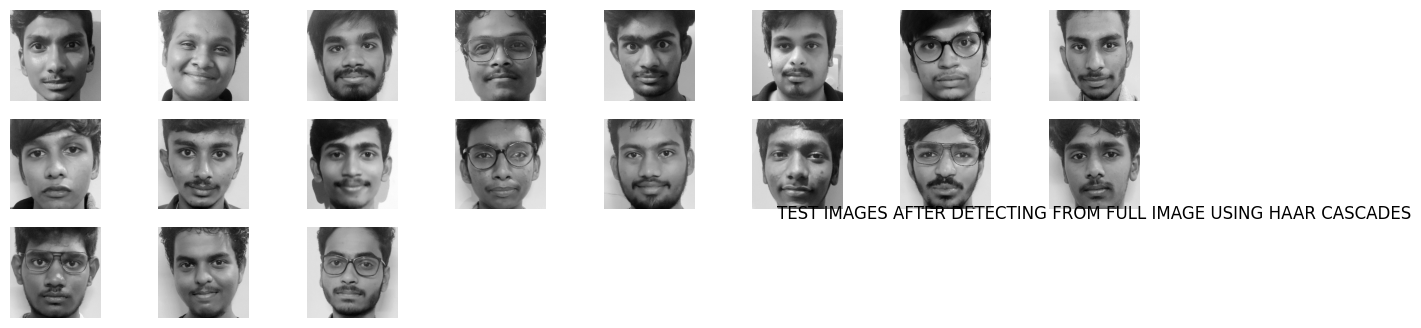

In [148]:
def face_detect (image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5)
    for i, (x, y, w, h) in enumerate(faces):
        face_image = image[y:y+h, x:x+w]
        len, brd = face_image.shape
        if len>200 and brd>200:
            break
    return face_image

test_images=[];K=0
for full_image in test_full_images:
    cropped_image = face_detect(full_image)
    cropped_img = cv2.resize(cropped_image,(l,b))
    cropped_img=np.array(cropped_img).flatten()
    test_images.append(cropped_img)
    #plot_face(cropped_img,test_names[K],l,b);K+=1

plot_images(test_images,l,b,8,"TEST IMAGES AFTER DETECTING FROM FULL IMAGE USING HAAR CASCADES")

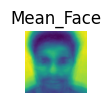

Standardized data diemntions :  (65536, 57)


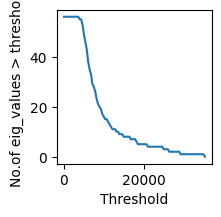

In [149]:

#MEAN FACE
images=np.array(train_images)
mean=np.mean(images,0)
plot_face(mean,"Mean_Face",l,b)

#STANDARDIZING THE DATA
std_data=images-mean
std_data=std_data.T
print("Standardized data diemntions : ",std_data.shape)

#APPLYING SVD
u,s,v=np.linalg.svd(std_data,full_matrices=False)

# Knowing the best value for considering the dimentions
# Calculate the threshold values
thresholds = np.linspace(s[-1], s[0], 100)

# Calculate the number of eigenvalues above each threshold value
num_eigvals_above_threshold = []
for threshold in thresholds:
    num_eigvals_above_threshold.append(np.sum(s> threshold))

# Plot the threshold graph
plt.figure(figsize=(2,2))
plt.plot(thresholds, num_eigvals_above_threshold)
plt.xlabel('Threshold')
plt.ylabel('No.of eig_values > threshold')
plt.show()



Eigen Faces


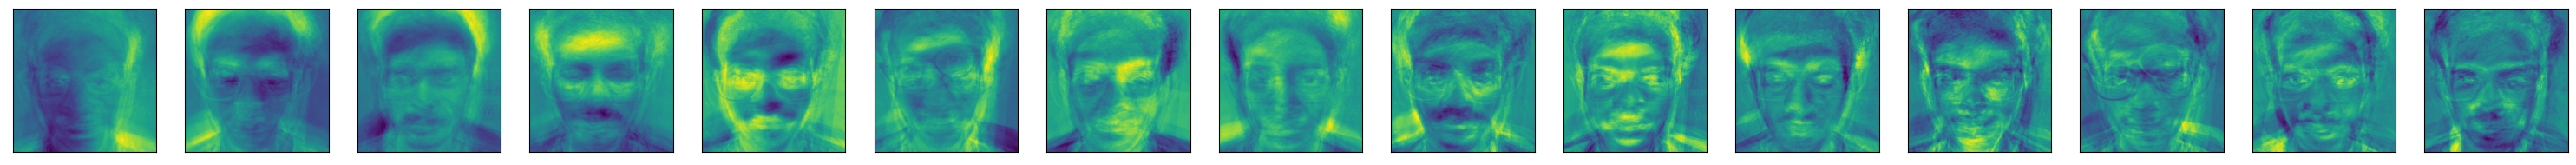

Training Matrix shape :  (983040, 57)


In [150]:

#DIMENTIONALITY REDUCTION
u=u[:,:15]
print("Eigen Faces")
plot_mul_faces(u,l,b)


#FORMING TRAINING MATRIX
train_mat=np.empty(shape=(u.shape[0]*u.shape[1],std_data.shape[1]))
proj=np.empty(shape=(u.shape[0],u.shape[1]))
for i in range(std_data.shape[1]):
    for j in range(u.shape[1]):
        proj[:,j]=std_data[:,i]*u[:,j]
    proj_flatten=np.array(proj).flatten()
    train_mat[:,i]=proj_flatten[:]
print("Training Matrix shape : ",train_mat.shape)

# TESTING PART
predicted_faces,keys=[],[]
for i in range(len(test_images)):
    test_face = test_images[i]

    norm_test=test_face-mean #normalizing the testing vectors
    test_vect=np.empty(shape=(u.shape[0],u.shape[1]))
    for i in range(u.shape[1]):
        test_vect[:,i]=norm_test*u[:,i]
    test_vect_flatten=np.array(test_vect).flatten()

    norms=[]
    subtract=np.empty(shape=(u.shape[0]*u.shape[1],std_data.shape[1]))
    subtract_norm=np.empty(shape=(std_data.shape[1]))

    for i in range(std_data.shape[1]):subtract[:,i]=train_mat[:,i]-test_vect_flatten
    for j in range(subtract.shape[1]):subtract_norm[j]=np.linalg.norm(subtract[:,j]);norms.append(subtract_norm[j])

    key_face=norms.index(min(norms))
    keys.append(key_face)
    predicted_faces.append(train_names[key_face])
    


Actual_face                                  -                               Predicted_face

AYUSH                                        -                                        RAHUL


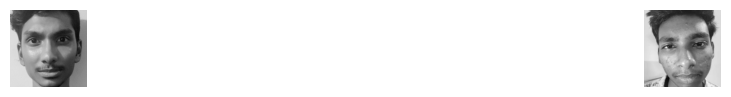

BHEESHMA                                     -                                       DANUSH


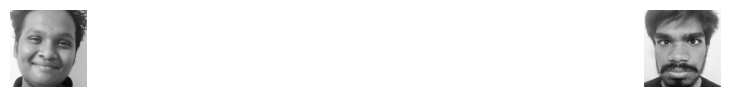

DANUSH                                       -                                       DANUSH


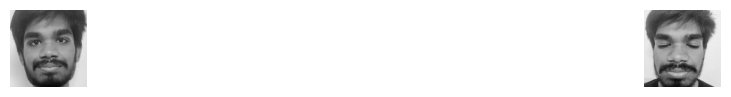

HEMANTH                                      -                                        RAHUL


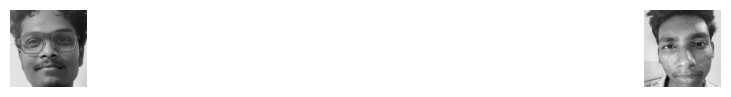

JOGI                                         -                                        RAHUL


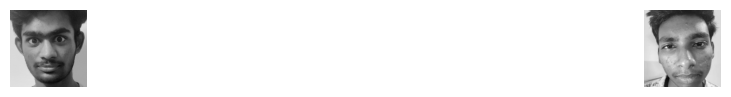

KARTHIKEYA                                   -                                     BHEESHMA


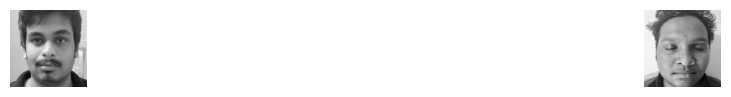

LEELA                                        -                                      SANJEEV


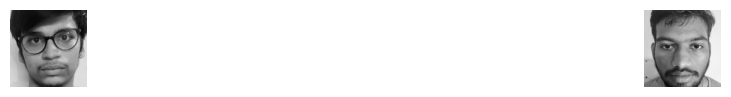

MADAN                                        -                                        RAHUL


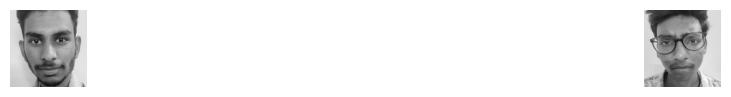

MAHESH                                       -                                       DANUSH


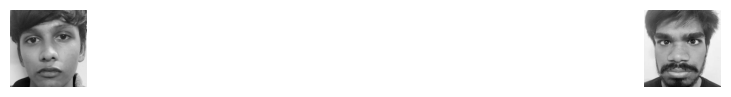

NITISH                                       -                                       DANUSH


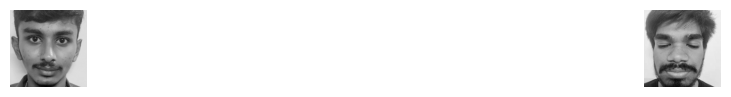

PARTHIV                                      -                                      SANJEEV


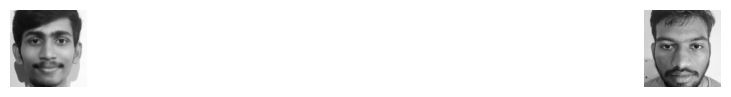

RAHUL                                        -                                      SANJEEV


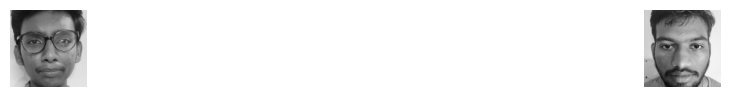

SANJEEV                                      -                                        RAHUL


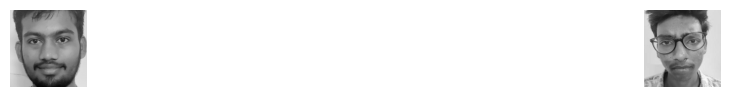

SHANMUKH                                     -                                        RAHUL


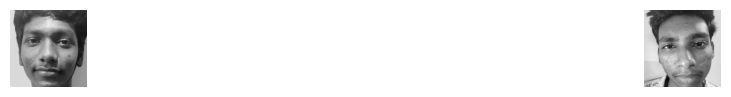

SIDDHU                                       -                                        RAHUL


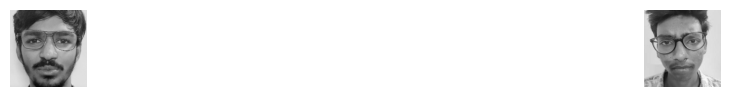

SWAPNITH                                     -                                        RAHUL


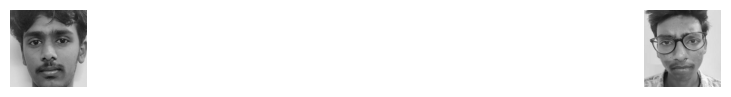

TEJA                                         -                                        RAHUL


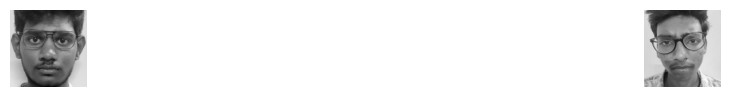

VAASANTH                                     -                                        RAHUL


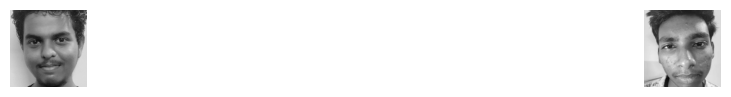

VIGNESH                                      -                                        RAHUL


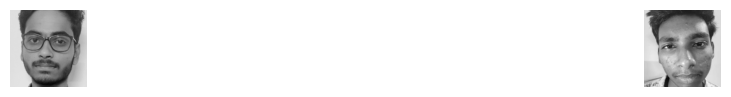



The accuracy of model is : 5.263157894736842


In [151]:
print("{:<45}-{:>45}\n".format("Actual_face","Predicted_face"))
for i in range(len(test_names)):
    print("{:<45}-{:>45}".format(test_names[i],predicted_faces[i]))
    #for plotting actual face and predicted face
    L=[test_images[i],train_images[keys[i]]]
    plot_images(L,l,b,2)

accuracy = accuracy_score(test_names,predicted_faces)
print("\n\nThe accuracy of model is :",accuracy*100)


In [152]:
# USING Support Vector Machine 
from sklearn import svm

model = svm.SVC()
model.fit(train_images,train_names)
y_pred  = model.predict(test_images)
accuracy = model.score(test_images, test_names)
print("Accuracy:", accuracy*100)

Accuracy: 10.526315789473683
